<div style="position: relative; text-align: center; background: #000; padding: 20px 10px; border-radius: 15px; box-shadow: 0 10px 25px rgba(0,0,0,0.7); font-family: 'Segoe UI', sans-serif; color: white;">

  <!-- تصویر بزرگ به عنوان عنوان -->
  <img src="https://i.postimg.cc/DwQ1QJn4/customer-behaviour-segmentation.webp" 
       alt="Title Image" 
       style="display: block; margin: 2px auto 5px auto; border-radius: 10px; box-shadow: 0 0 10px #666;">
  
  <!-- اسم کوچیک سمت چپ بالا -->
  <span style="
  color: #B8860B;
  font-family: 'Times New Roman', Times, serif;
  font-weight: bold;
  padding-bottom: 2px;
">
  Samane Najarian
</span>

</div>

# 💡 Data Mining Final Project: Customer Behavioral Segmentation and Profiling

## 📚 Introduction

This project involves the analysis of a dataset related to a charity group. The dataset contains general information about the members and a list of their donations over a specific period, stored in two separate files named BenefactorsData.csv and TransactionalData.csv.

- **BenefactorsData.csv:** This file includes the membership ID, gender, State, date of birth, and how members became acquainted with the charity group.  
- **TransactionalData.csv:** This file includes the unique transaction code along with the date and amount of the donation, and the type of donation made by each group member.

---

## 🎯 Project Aim

The charity group is interested in using data science tools to design marketing strategies aimed at determining the appropriate target group and profiling the behavioral patterns of its members. The goal is to design and implement advertising campaigns. The expected outcomes of this project are:

- **🔸 Segmentation of Members:** Based on donation history and behavioral indicators, members can be divided into several manageable groups. This segmentation will reveal the current behavioral patterns of the members.

- **🔸 Target Market Identification:** By understanding the behavioral patterns, the charity group can select suitable behavioral patterns for campaign implementation.

- **🔸 Profiling Members:** Exploring the relationship between initial member information (such as gender, age, etc.) and identified behavioral patterns. This profiling will provide insights into key characteristics of potential benefactors, helping the charity group in targeting and engaging with them effectively.

---


In [50]:
# 1-Import Libraies
import numpy as np
import pandas as pd
#!pip install ydata-profiling
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
!pip install jdatetime
import jdatetime
import datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from scipy.stats import ttest_ind, chi2_contingency
from sklearn.tree import DecisionTreeClassifier, export_text
import plotly.graph_objects as go
from scipy.stats import norm

# Modelling
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import _tree

# Validation
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import f1_score, make_scorer
#pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (16, 9)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


#!pip install ydata_profiling
# !pip install -U pandas-profiling --user
#import pandas_profiling
#from pandas_profiling.report.presentation.flavours.html.templates import create_html_assets

## 🧹 Data Preprocessing for Taransactional Dataset

### 🗂 Loading the Taransactional Dataset

- Reading the Datasets: Load the TransactionalData.csv files into pandas DataFrames.

In [51]:
Transactional = pd.read_csv("/kaggle/input/customer-behavioral-segmentation-and-profiling/TransactionalData.csv")
Transactional = Transactional.drop('Unnamed: 0', axis=1)

Transactional.head()

,TransID,UserID,PaymentDate,PaymentAmount,SupportType
0,850001,174731,2016-03-20,200000,Membership Fee
1,850002,51006,2016-03-20,3000000,Cash
2,850003,145833,2016-03-20,50000,Membership Fee
3,850004,177032,2016-03-20,22000,Membership Fee
4,850005,147147,2016-03-20,50000,Membership Fee


In [52]:
print("Shape:", Transactional.shape)

Shape: (1490797, 5)


In [53]:
print(Transactional.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490797 entries, 0 to 1490796
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   TransID        1490797 non-null  int64 
 1   UserID         1490797 non-null  int64 
 2   PaymentDate    1490797 non-null  object
 3   PaymentAmount  1490797 non-null  int64 
 4   SupportType    1490797 non-null  object
dtypes: int64(3), object(2)
memory usage: 56.9+ MB
None


In [54]:
profile_Transactional = ProfileReport(Transactional, title="Transactional data EDA", type_schema = {"Ed": "categorical", "Default": "categorical"})

#profile_Transactional.to_file("transactional_dataset_profile_report.html")

---
## 📥 Transactional Data Processing

## 🔬 Exploratory Data Analysis (EDA)

- Perform EDA to check data quality.


---
## ✂️ Filter Transactions

- Select transactions with PaymentAmount greater than 1000.
-  Select transactions with 'Membership Fee' in SupportType. Explain why this selection is important? 

In [55]:
Filtered_Transactional = Transactional[(Transactional['PaymentAmount']>1000) &
                                       (Transactional['SupportType'] == "Membership Fee")]

---
### 🧮 Aggregate Transactional Data

- First Stage: Aggregate the data by UserID and PaymentDate.  
- Second Stage: Aggregate the results of the first stage by UserID to construct the R, F, and M fields:  
  - R (Recency): The number of days since the last donation.  
  - F (Frequency): The number of donations.  
  - M (Monetary): The total amount donated.  
  - D (Duration): The number of days between the first and last donation.

In [56]:
Aggregated_Transactional = Filtered_Transactional.groupby(['UserID','PaymentDate'])['PaymentAmount'].sum().reset_index()

Aggregated_Transactional.head()

,UserID,PaymentDate,PaymentAmount
0,0,2016-09-13,300000
1,0,2017-09-13,500000
2,1,2018-06-15,150000
3,3,2016-08-11,40000
4,3,2016-09-24,50000


In [57]:
Aggregated_Transactional['PaymentDate'] = pd.to_datetime(Aggregated_Transactional['PaymentDate'])
last_date = Aggregated_Transactional['PaymentDate'].max()

RFMD = Aggregated_Transactional.groupby('UserID').agg(
    R=('PaymentDate', lambda x: (last_date - x.max()).days),
    F=('PaymentDate','nunique'),
    M=('PaymentAmount','sum'),
    D=('PaymentDate', lambda x: (x.max() - x.min()).days)
).reset_index()

In [58]:
profile_RFMD = ProfileReport(RFMD, title="RFMD data EDA", type_schema = {"Ed": "categorical", "Default": "categorical"})

#profile_RFMD.to_file("RFMD_dataset_profile_report.html")

---
### 📈 EDA on Aggregated Data

- Perform EDA to check the quality indexes in the aggregated data and explore the distributions of R, F, M, and D.

### 🎛️ Categorize and Score R, F, M, and D

- R (Recency):  
  - 0 <= R < 60  
  - 60 <= R < 180  
  - 180 <= R < 365  
  - 365 <= R < 545  
  - R >= 545  

- F (Frequency):  
  - 1 <= F < 2  
  - 2 <= F < 5  
  - 5 <= F < 10  
  - 10 <= F < 20  
  - F >= 20  

- M (Monetary):  
  - 0 <= M < 500,000  
  - 500,000 <= M < 1,200,000  
  - 1,200,000 <= M < 2,500,000  
  - 2,500,000 <= M < 10,000,000  
  - M >= 10,000,000  

- D (Duration):  
  - 0 <= D < 1  
  - 1 <= D < 180  
  - 180 <= D < 365  
  - 365 <= D < 545  
  - D >= 545  


In [59]:
bins_dict = {
    'R': [0, 60, 180, 365, 545, float('inf')],
    'F': [1, 2, 5, 10, 20, float('inf')],
    'M': [0, 500000, 1200000, 2500000, 10000000, float('inf')],
    'D': [0, 1, 180, 365, 545, float('inf')]
}

for col in ['R', 'F', 'M', 'D']:
    if col == 'R':
        RFMD[f'{col}_Score'] = pd.cut(RFMD[col], bins=bins_dict[col], labels=[5, 4, 3, 2, 1], right=False)
    else:
        RFMD[f'{col}_Score'] = pd.cut(RFMD[col], bins=bins_dict[col], labels=[1, 2, 3, 4, 5], right=False)

RFMD.drop(columns=['R', 'F', 'M', 'D'], inplace=True)

RFMD.head()

,UserID,R_Score,F_Score,M_Score,D_Score
0,0,3,2,2,4
1,1,4,1,1,1
2,3,3,3,1,4
3,5,2,1,5,1
4,11,1,1,1,1


---

## 🤖 Data Modeling

### 🗂️ Clustering Model

- To identify customer behavioral patterns  
- Perform k-means clustering model with 2 to 6 clusters on the R, F, M, and D fields.  
- Evaluate the fitted clustering models using KElbowVisualizer.  
- Explore the clusters and describe customer behavioral patterns.  
- Select the best model based on cluster descriptions and silhouette score.  
- Choose a pattern as a target group and construct a binary target field for each customer based on that pattern.

----
# <p style="font-family:newtimeroman;color:#FFD700;font-size:70%;text-align:center;border-radius:10px 10px;">Fitting K-Means Model</p>

In [60]:
X = RFMD[['R_Score','F_Score','M_Score', 'D_Score']]

cluster_range = range(2, 7)  

# List to store WCSS values
wss = []
silhouette_scores = []

# Calculate WCSS for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init='auto', max_iter=100,
                    tol=0.0001, random_state=880, algorithm='lloyd')
    kmeans.fit(X)
    wss.append(kmeans.inertia_)
    labels = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

In [61]:
cluster_metrics = pd.DataFrame({
    'Number of Clusters': list(cluster_range),
    'WCSS': wss,
    'Silhouette Score': silhouette_scores
})

cluster_metrics

,Number of Clusters,WCSS,Silhouette Score
0,2,365598.81,0.45
1,3,287332.73,0.35
2,4,237573.47,0.32
3,5,200040.85,0.34
4,6,180406.45,0.33


----
# <p style="font-family:newtimeroman;color:#FFD700;font-size:90%;text-align:center;border-radius:10px 10px;">Vidualization</p>

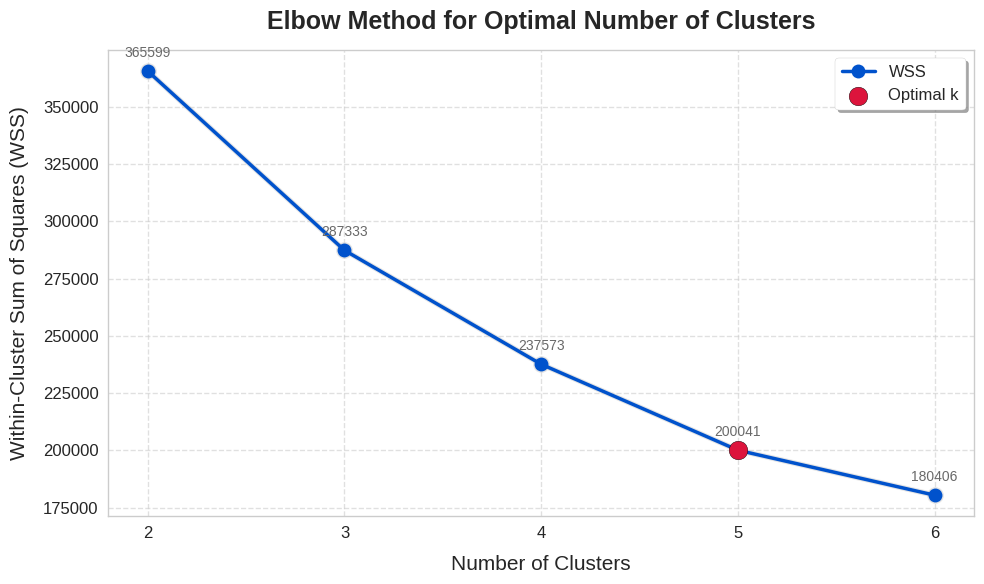

In [62]:
plt.style.use('seaborn-v0_8-whitegrid')

k_opt = 5  

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(cluster_range, [w + 10 for w in wss], 
        marker='o', markersize=12, linewidth=4, color='lightgray', alpha=0.6, zorder=1)

ax.plot(cluster_range, wss, marker='o', markersize=10, linewidth=2.5, color='#0052cc', zorder=2, label='WSS')

ax.scatter(k_opt, wss[cluster_range.index(k_opt)], 
           color='crimson', s=180, edgecolor='black', zorder=3, label='Optimal k')

ax.set_title('Elbow Method for Optimal Number of Clusters', fontsize=18, fontweight='bold', pad=15)
ax.set_xlabel('Number of Clusters', fontsize=15, labelpad=10)
ax.set_ylabel('Within-Cluster Sum of Squares (WSS)', fontsize=15, labelpad=10)

for i, txt in enumerate(wss):
    ax.annotate(f"{txt:.0f}", (cluster_range[i], wss[i]), 
                textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='dimgray')

ax.set_xticks(cluster_range)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=12, frameon=True, shadow=True)

plt.tight_layout()
plt.show()

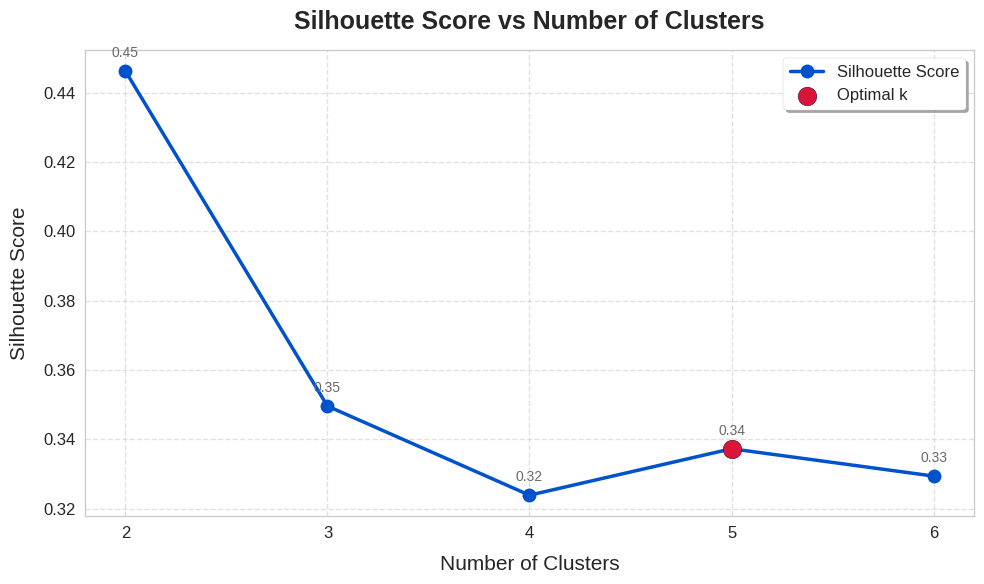

In [63]:
plt.style.use('seaborn-v0_8-whitegrid')

k_opt = 5

fig, ax = plt.subplots(figsize=(10, 6))


ax.plot(cluster_range, silhouette_scores, marker='o', markersize=10, linewidth=2.5, 
        color='#0052cc', zorder=2, label='Silhouette Score')

ax.scatter(k_opt, silhouette_scores[cluster_range.index(k_opt)],
           color='crimson', s=180, edgecolor='black', zorder=3, label='Optimal k')

ax.set_title('Silhouette Score vs Number of Clusters', fontsize=18, fontweight='bold', pad=15)
ax.set_xlabel('Number of Clusters', fontsize=15, labelpad=10)
ax.set_ylabel('Silhouette Score', fontsize=15, labelpad=10)

for i, txt in enumerate(silhouette_scores):
    ax.annotate(f"{txt:.2f}", (cluster_range[i], silhouette_scores[i]),
                textcoords="offset points", xytext=(0, 10), ha='center',
                fontsize=10, color='dimgray')

ax.set_xticks(cluster_range)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=12, frameon=True, shadow=True)

plt.tight_layout()
plt.show()

----
# <p style="font-family:newtimeroman;color:#FFD700;font-size:90%;text-align:center;border-radius:10px 10px;">Best Model</p>

In [64]:
# Initialize the KMeans model
km_model = KMeans(n_clusters=5, init='k-means++', n_init='auto', max_iter=300,
                  tol=0.0001, random_state=880, algorithm='lloyd')

# Fit the model
km_model.fit(X)

# Predict the cluster labels
labels = km_model.predict(X)

# Compute the silhouette score
silhouette_avg = silhouette_score(X, labels)
silhouette = silhouette_samples(X, labels)

print(f'Silhouette Score: {silhouette_avg}')

X_kmeans = X.copy()
X_kmeans['Cluster'] = labels
X_kmeans['Silhouette'] = silhouette
X_kmeans.index = RFMD['UserID']

X_kmeans.head()

Silhouette Score: 0.3372585032974422


,R_Score,F_Score,M_Score,D_Score,Cluster,Silhouette
UserID,,,,,,
0,3,2,2,4,0,0.15
1,4,1,1,1,4,0.56
3,3,3,1,4,0,0.41
5,2,1,5,1,2,0.08
11,1,1,1,1,2,0.58


In [65]:
wss = km_model.inertia_
print(f"WSS: {wss:.2f}")

print("-"*80)

centers = km_model.cluster_centers_
print("Cluster Centers:\n", centers)

WSS: 200040.85
--------------------------------------------------------------------------------
Cluster Centers:
 [[3.91359689 3.01642208 1.37745832 3.745882  ]
 [3.3119244  2.75294306 3.69936734 3.81909186]
 [1.4648154  1.39251341 1.4926633  1.43964973]
 [4.77906977 4.55395349 3.74118863 4.79204134]
 [3.81987687 1.34758135 1.43764292 1.34347699]]


---
# <p style="font-family:newtimeroman;color:#FFD700;font-size:70%;text-align:center;border-radius:10px 10px;">Distribution of Scores for Each Cluster
</p>

In [66]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Define the score column names

X_kmeans['Cluster'] = X_kmeans['Cluster'] + 1
clusters = sorted(X_kmeans['Cluster'].unique())

# Ensure the score columns are of float type
scores = ['R_Score', 'F_Score', 'M_Score', 'D_Score']
X_kmeans[scores] = X_kmeans[scores].astype(float)

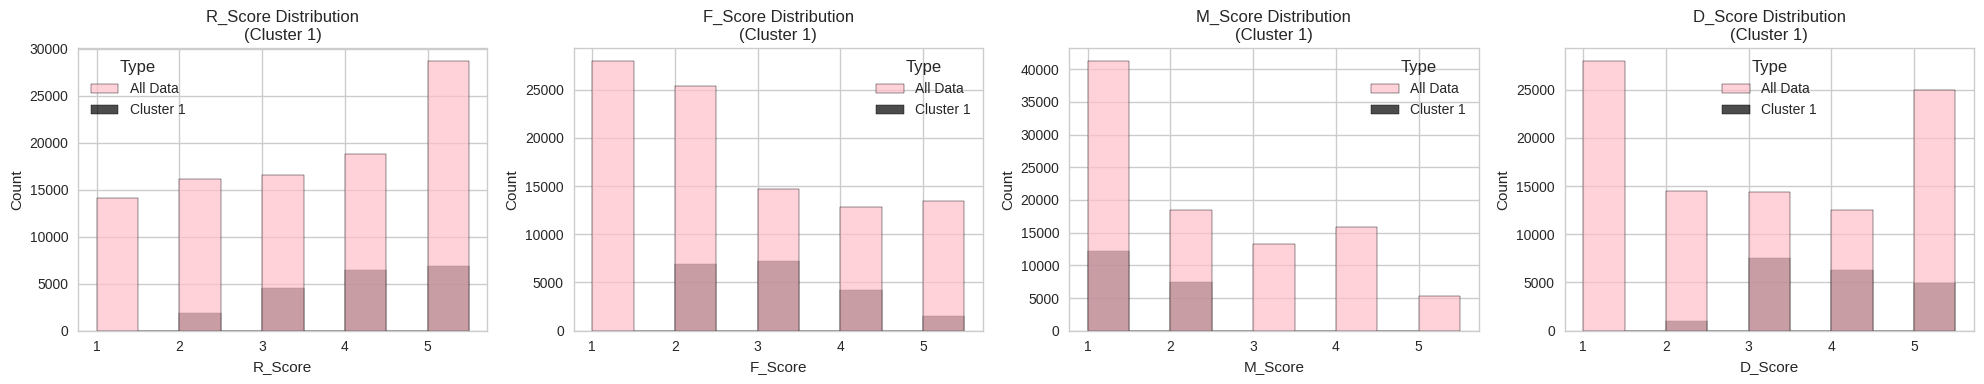

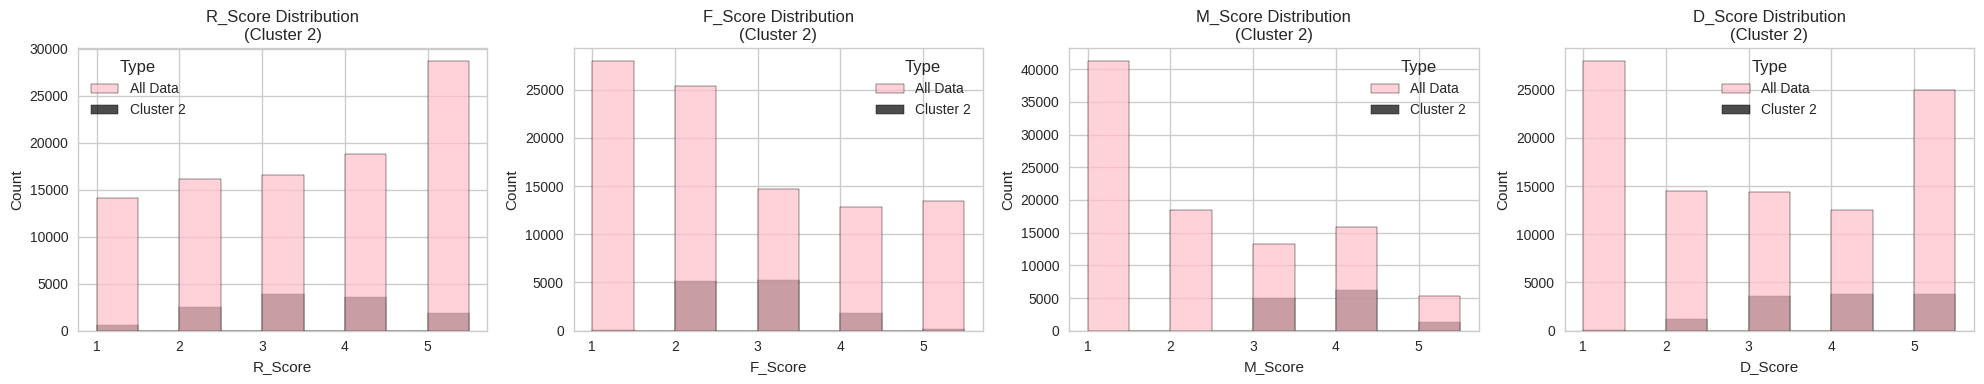

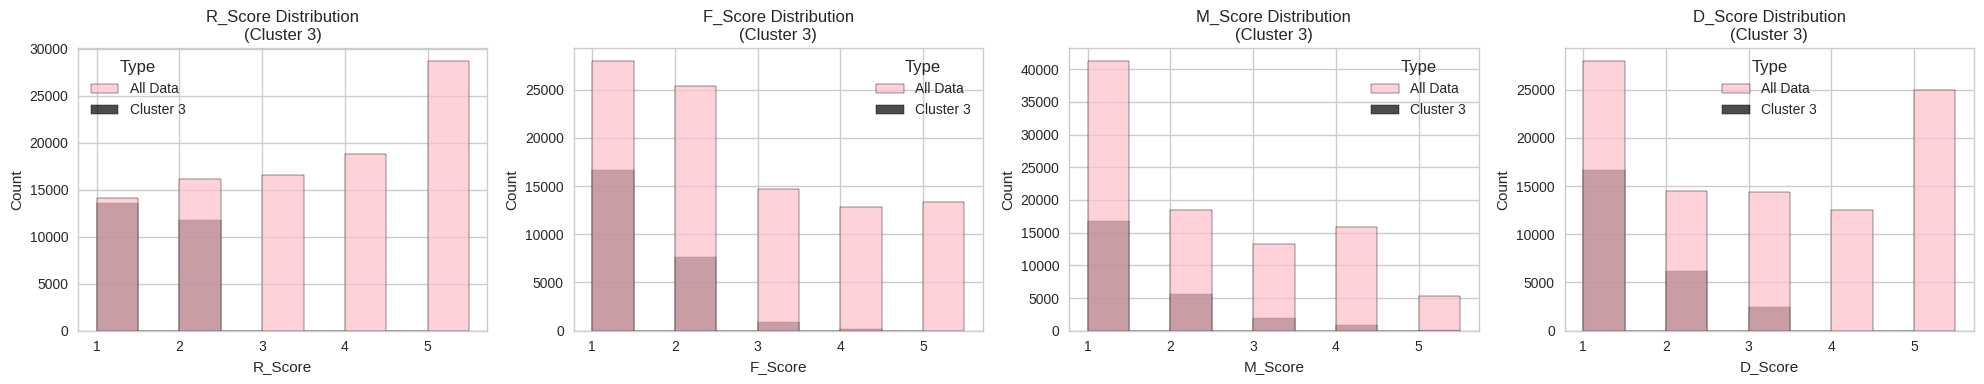

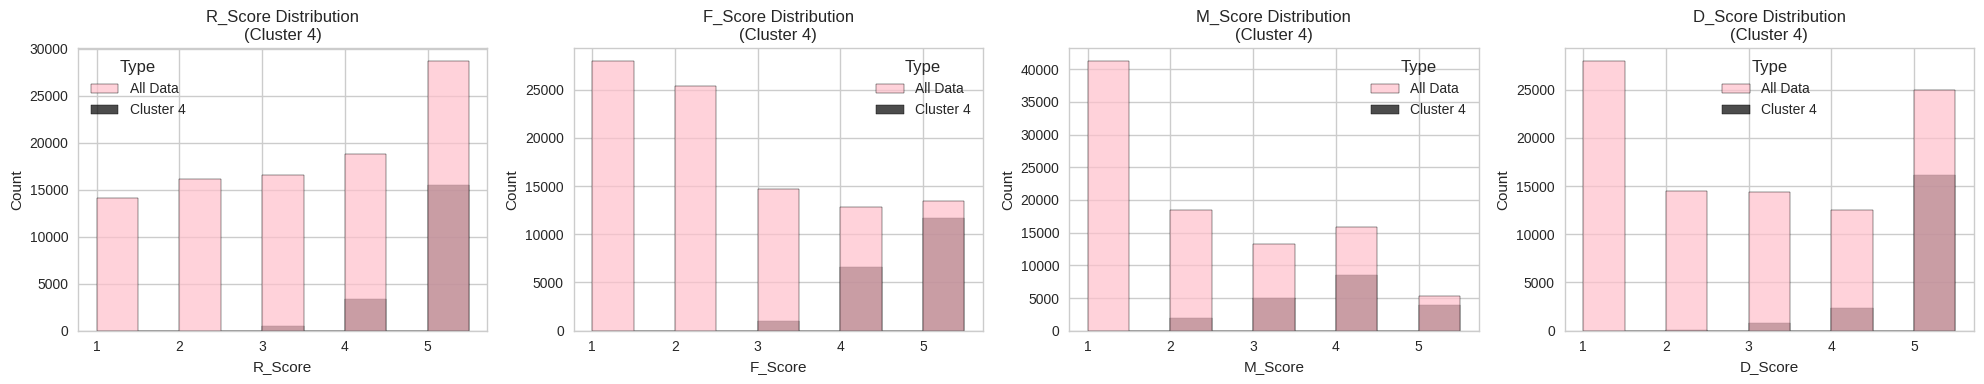

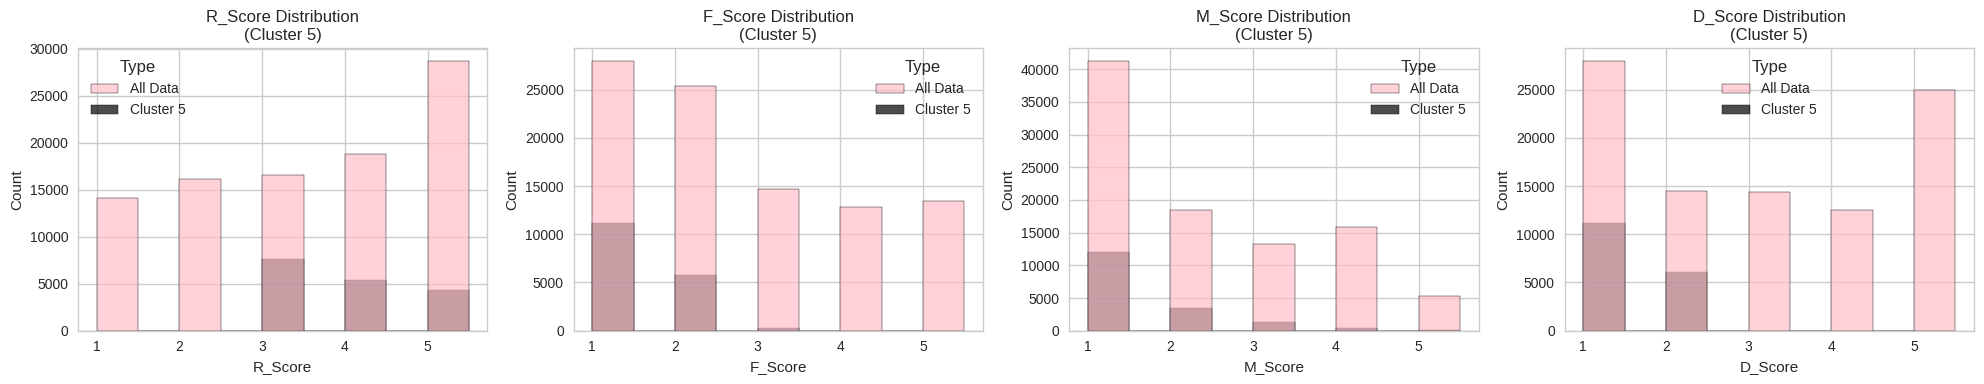

In [67]:
# Loop through each cluster
for cluster in clusters:
    # Create subplots: one for each score
    fig, axes = plt.subplots(1, len(scores), figsize=(20, 4))
    
    for i, score in enumerate(scores):
        ax = axes[i]

        # Create DataFrame for all data and for the specific cluster
        all_data = pd.DataFrame({score: X_kmeans[score], 'Type': 'All Data'})
        data_cluster = pd.DataFrame({
            score: X_kmeans.loc[X_kmeans['Cluster'] == cluster, score],
            'Type': f'Cluster {cluster}'
        })
        # Combine both DataFrames for plotting
        data_combined = pd.concat([all_data, data_cluster])

        # Add half-unit jitter to the score for better visualization
        data_combined[score+'_float'] = data_combined[score] + np.random.uniform(0, 0.5, len(data_combined))

        # Define bins with 0.5 spacing
        bins = np.arange(data_combined[score+'_float'].min(),
                         data_combined[score+'_float'].max() + 0.5,
                         0.5)

        # Plot histogram with hue for cluster vs all data
        sns.histplot(
            x=score+'_float',
            hue='Type',
            data=data_combined,
            ax=ax,
            palette=['pink', 'black'],
            bins=bins,
            stat='count',
            alpha=0.7
        )

        # Set title and axis labels
        ax.set_title(f'{score} Distribution\n(Cluster {cluster})')
        ax.set_xlabel(score)
        ax.set_ylabel('Count')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

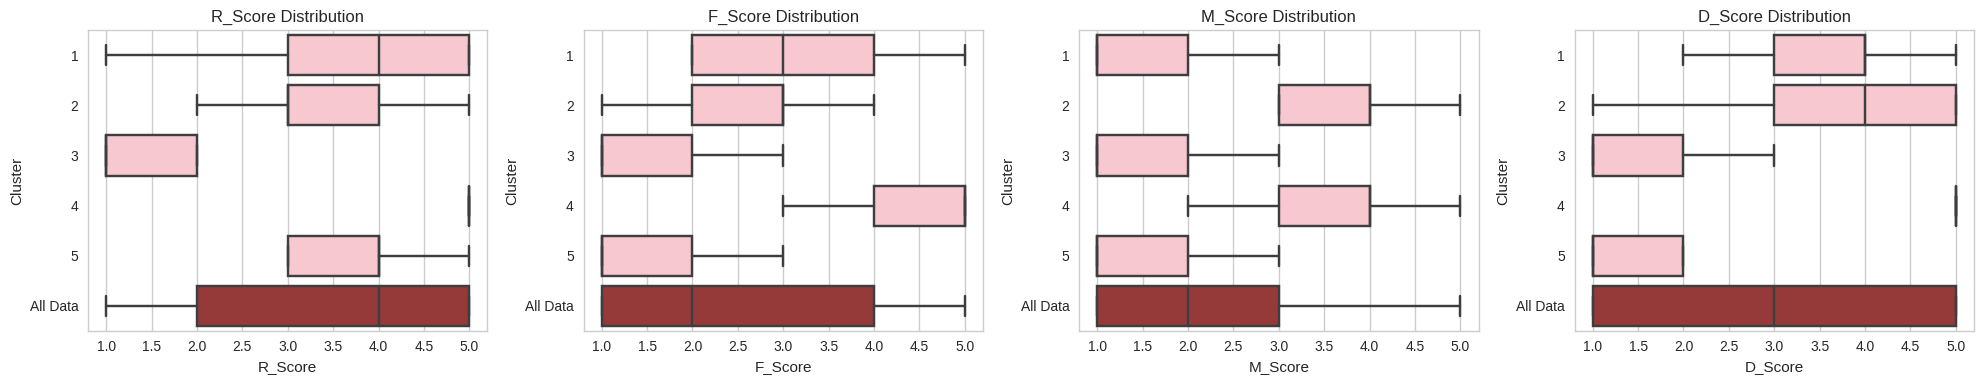

In [68]:
# Set up the matplotlib figure
fig, axes = plt.subplots(1, len(scores), figsize=(20, 4))

# Define the colors
pink_color = 'pink'  
dark_pink_color = 'brown'  

# Loop over each score and create a horizontal box plot
for i, score in enumerate(scores):
    ax = axes[i]    
    
    # Create a DataFrame for all data
    df_all_data = X_kmeans[[score]].copy()
    df_all_data['Cluster'] = 'All Data'

    # Combine the all data DataFrame with the original DataFrame
    combined_df = pd.concat([X_kmeans[['Cluster', score]], df_all_data], ignore_index=True)

    # Sort the clusters including 'All Data'
    combined_df['Cluster'] = pd.Categorical(combined_df['Cluster'], categories= clusters + ['All Data'], ordered=True)

    # Create a horizontal box plot
    sns.boxplot(y='Cluster', x=score, data=combined_df, palette= [pink_color] * len(clusters) + [dark_pink_color], ax=ax, showfliers=False)

    # Set the title and labels
    ax.set_title(f'{score} Distribution')
    ax.set_xlabel(score)
    ax.set_ylabel('Cluster')

plt.tight_layout()
plt.show()

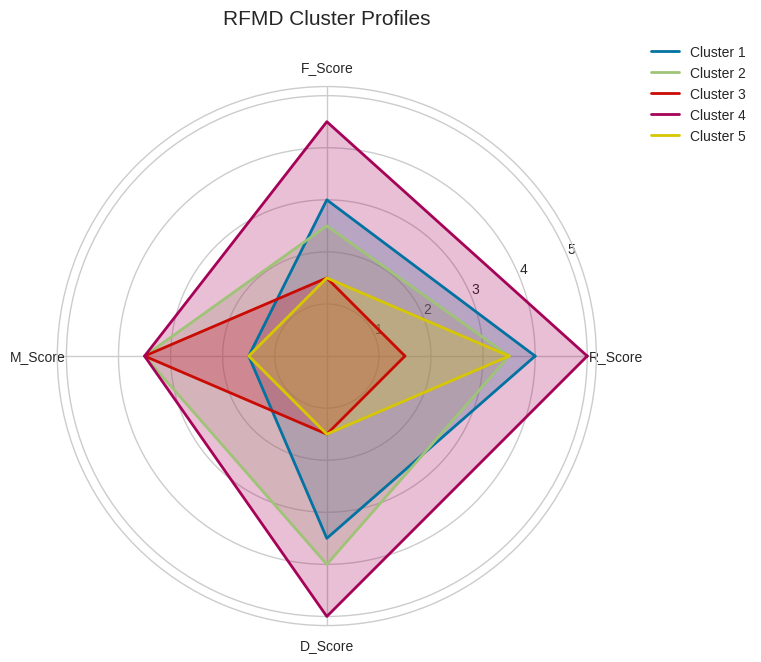

In [69]:
radar_data = pd.DataFrame({
    'Cluster': [1, 2, 3, 4, 5],
    'R_Score': [4, 3.5, 1.5, 5, 3.5],     
    'F_Score': [3, 2.5, 1.5, 4.5, 1.5],      
    'M_Score': [1.5, 3.5, 3.5, 3.5, 1.5],      
    'D_Score': [3.5, 4, 1.5, 5, 1.5]       
})

cluster_profiles = radar_data.groupby('Cluster').mean()

labels = cluster_profiles.columns
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

for cluster in cluster_profiles.index:
    values = cluster_profiles.loc[cluster].tolist()
    values += values[:1]  # بستن حلقه
    ax.plot(angles, values, linewidth=2, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(['1', '2', '3', '4', '5'])
plt.title("RFMD Cluster Profiles", size=15, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

---
# <p style="font-family:newtimeroman;color:#FFD700;font-size:70%;text-align:center;border-radius:10px 10px;">Cluster Summary Table</p>

In [70]:
# ---------------------------
# 1. Calculate cluster means
# ---------------------------
cluster_summary = X_kmeans.groupby('Cluster').mean().reset_index()

# Rename columns for clarity
cluster_summary.columns = [
    'Cluster', 
    'mean_Recency_Score', 
    'mean_Frequency_Score', 
    'mean_Monetary_Score',
    'mean_Duration_Score', 
    'mean_Silhouette'
]

# ---------------------------
# 2. Calculate counts and percentages
# ---------------------------
cluster_counts = X_kmeans['Cluster'].value_counts().sort_index().reset_index()
cluster_counts.columns = ['Cluster', 'count']
cluster_counts['percentage'] = (cluster_counts['count'] / len(X_kmeans)) * 100

# Merge counts with summary
cluster_summary = pd.merge(cluster_summary, cluster_counts, on='Cluster')

# ---------------------------
# 3. Calculate overall mean
# ---------------------------
overall_mean = X_kmeans[['R_Score', 'F_Score', 'M_Score', 'D_Score', 'Silhouette']].mean().to_frame().T
overall_mean['Cluster'] = 'All Data'
overall_mean['count'] = len(X_kmeans)
overall_mean['percentage'] = 100.0
overall_mean.columns = [
    'mean_Recency_Score', 
    'mean_Frequency_Score', 
    'mean_Monetary_Score', 
    'mean_Duration_Score', 
    'mean_Silhouette', 
    'Cluster', 
    'count', 
    'percentage'
]

# Append overall mean
cluster_summary = pd.concat([cluster_summary, overall_mean], ignore_index=True)

# ---------------------------
# 4. Replace cluster codes with names
# ---------------------------
cluster_name = {
    '1': 'Steady Supporters',
    '2': 'Engaging Supporters',
    '3': 'Churn Supporters',
    '4': 'VIP Supporters',
    '5': 'Fresh Supporters'
}

# Only replace numeric clusters
cluster_summary['Cluster'] = cluster_summary['Cluster'].astype(str).replace(cluster_name)

# ---------------------------
# 5. View final summary
# ---------------------------
cluster_summary


,Cluster,mean_Recency_Score,mean_Frequency_Score,mean_Monetary_Score,mean_Duration_Score,mean_Silhouette,count,percentage
0,Steady Supporters,3.93,3.02,1.38,3.77,0.20,19776,20.98
1,Engaging Supporters,3.31,2.75,3.70,3.82,0.16,12487,13.24
2,Churn Supporters,1.46,1.39,1.49,1.44,0.42,25352,26.89
3,VIP Supporters,4.78,4.55,3.74,4.79,0.46,19350,20.52
4,Fresh Supporters,3.81,1.37,1.43,1.35,0.36,17313,18.36
5,All Data,3.34,2.56,2.21,2.92,0.34,94278,100.00


---
## 🧹 Data Preprocessing for Benefactors Dataset

### 🗂 Loading the Benefactors Dataset

- Reading the Datasets: Load the BenefactorsData.csv files into pandas DataFrames.

In [71]:
Benefactors = pd.read_csv("/kaggle/input/customer-behavioral-segmentation-and-profiling/BenefactorsData.csv")
Benefactors = Benefactors.drop('Unnamed: 0', axis=1)
Benefactors = Benefactors.set_index('UserID')

Benefactors.head()

,Gender,State,BirthDate,ReferralSource
UserID,,,,
3,زن,تهران,1363-08-16,Acquaintances
8,مرد,تهران,1364-06-24,Acquaintances
14,مرد,تهران,1356-07-07,Acquaintances
17,زن,تهران,1325-07-23,Acquaintances
18,زن,تهران,1334-10-06,Acquaintances


In [72]:
print("Shape:", Benefactors.shape)

Shape: (278386, 4)


In [73]:
print( Benefactors.info())

<class 'pandas.core.frame.DataFrame'>
Index: 278386 entries, 3 to 262143
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Gender          278149 non-null  object
 1   State           278386 non-null  object
 2   BirthDate       221817 non-null  object
 3   ReferralSource  278386 non-null  object
dtypes: object(4)
memory usage: 10.6+ MB
None


In [74]:
profile_Benefactors = ProfileReport(Benefactors, title="Benefactors data EDA", type_schema = {"Ed": "categorical", "Default": "categorical"})

#profile_Benefactors.to_file("benefactors_dataset_profile_report.html")

---
## 👥 Benefactors Data Processing

### 🔍 EDA

- Perform EDA to check data quality.

### 📆 Extract and Calculate Age

- Extract the year from BirthDate.  
- Calculate the age of each customer by subtracting the birth year from the maximum year of the transaction date.  
- Explain an idea to calculate a more accurate age for each customer.  
- Use the interval (0, 100) as a logical range for age.  
- Categorize Age into four categories:  
  - 0-20  
  - 20-35  
  - 35-50  
  - Age >= 50  

In [75]:
def calculate_age(df, date_col='BirthDate', reference_date=None):
    if reference_date is None:
        reference_date = datetime.today()

    def to_gregorian(persian_date_str):
        try:
            if pd.isna(persian_date_str):
                return pd.NaT
            y, m, d = map(int, str(persian_date_str).split('-'))
            return jdatetime.date(y, m, d).togregorian()  # returns a datetime.date
        except Exception:
            return pd.NaT

    greg_dates = df[date_col].apply(to_gregorian)

    def calculate_age_from_date(birthdate):
        if pd.isna(birthdate):
            return pd.NA

        age = reference_date.year - birthdate.year

        # Subtract 1 ONLY if the birthday has not occurred yet in the reference year
        # i.e., birth month/day is AFTER reference month/day
        if (birthdate.month > reference_date.month) or (
            birthdate.month == reference_date.month and birthdate.day > reference_date.day
        ):
            age -= 1

        # Keep only logical ages
        if age < 0 or age > 100:
            return pd.NA
        return age

    ages = greg_dates.apply(calculate_age_from_date).astype('Int64')
    return ages


In [76]:
def persian_to_gregorian(persian_date_str):
    try:
        if pd.isna(persian_date_str):
            return pd.NaT
        y, m, d = map(int, str(persian_date_str).split('-'))
        greg_date = jdatetime.date(y, m, d).togregorian()
        return pd.to_datetime(greg_date)
    except Exception:
        return pd.NaT

Benefactors['BirthDate_Gregorian'] = Benefactors['BirthDate'].apply(persian_to_gregorian)
Benefactors.head()

,Gender,State,BirthDate,ReferralSource,BirthDate_Gregorian
UserID,,,,,
3,زن,تهران,1363-08-16,Acquaintances,1984-11-07
8,مرد,تهران,1364-06-24,Acquaintances,1985-09-15
14,مرد,تهران,1356-07-07,Acquaintances,1977-09-29
17,زن,تهران,1325-07-23,Acquaintances,1946-10-15
18,زن,تهران,1334-10-06,Acquaintances,1955-12-28


In [77]:
max_transaction_date = pd.to_datetime(Aggregated_Transactional['PaymentDate']).max()
Benefactors['Age'] = calculate_age(Benefactors, 'BirthDate', reference_date=max_transaction_date)
Benefactors = Benefactors.drop(columns=['BirthDate','BirthDate_Gregorian'])
Benefactors.head()

,Gender,State,ReferralSource,Age
UserID,,,,
3,زن,تهران,Acquaintances,33
8,مرد,تهران,Acquaintances,32
14,مرد,تهران,Acquaintances,40
17,زن,تهران,Acquaintances,71
18,زن,تهران,Acquaintances,62


In [78]:
bins = [0, 20, 35, 50, float('inf')]
labels = ['0-20', '20-35', '35-50', '50+']

Benefactors['AgeCategory'] = pd.cut(Benefactors['Age'], bins=bins, labels=labels, right=False)
Benefactors = Benefactors.drop(columns=['Age'])

Benefactors.head()

,Gender,State,ReferralSource,AgeCategory
UserID,,,,
3,زن,تهران,Acquaintances,20-35
8,مرد,تهران,Acquaintances,20-35
14,مرد,تهران,Acquaintances,35-50
17,زن,تهران,Acquaintances,50+
18,زن,تهران,Acquaintances,50+


In [79]:
Benefactors['Gender'] = Benefactors['Gender'].replace({'زن': 'F', 'مرد': 'M'})

---
### 🏙 State Classification

- Classify State into three categories:  
  - Tehran  
  - Alborz  
  - Other  


In [80]:
Benefactors['StateCategory'] = np.where(
    Benefactors['State'] == 'تهران', 'Tehran',
    np.where(Benefactors['State'] == 'البرز', 'Alborz', 'Other')
)
Benefactors = Benefactors.drop(columns = 'State')

Benefactors.head()

,Gender,ReferralSource,AgeCategory,StateCategory
UserID,,,,
3,F,Acquaintances,20-35,Tehran
8,M,Acquaintances,20-35,Tehran
14,M,Acquaintances,35-50,Tehran
17,F,Acquaintances,50+,Tehran
18,F,Acquaintances,50+,Tehran


---

## ⚠️ Handling Missing Values

- Handle missing values to ensure the dataset is complete: Use the median or mode for fields with less than 5% missing values, and apply KNN modeling techniques for fields with 5% or more missing values.

In [81]:
np.sum(Benefactors.isnull())

Gender              237
ReferralSource        0
AgeCategory       56627
StateCategory         0
dtype: int64

In [84]:
missing_pct = Benefactors.isnull().mean() * 100

cols_less_equal_5pct = missing_pct[missing_pct <= 5]
cols_more_than_5pct = missing_pct[missing_pct > 5]

print("Columns with missing percentage less than or equal to 5%:\n", cols_less_equal_5pct)
print('-'*80)
print("\nColumns with missing percentage greater than 5%:\n", cols_more_than_5pct)

Columns with missing percentage less than or equal to 5%:
 Gender           0.09
ReferralSource   0.00
StateCategory    0.00
dtype: float64
--------------------------------------------------------------------------------

Columns with missing percentage greater than 5%:
 AgeCategory   20.34
dtype: float64


In [85]:
def simple_impute_under_5pct(df, threshold=0.05):
    """
    Fill missing values for columns with less than threshold missing:
    - numeric → median
    - categorical → mode
    """
    df = df.copy()  
    #df.set_index('UserID', inplace=True)

    for col in df.columns:
        missing_pct = df[col].isna().mean()
        if 0 < missing_pct < threshold:
            if np.issubdtype(df[col].dtype, np.number):
                df[col].fillna(df[col].median(), inplace=True)
            else:  
                df[col].fillna(df[col].mode()[0], inplace=True)
    
    return df

In [86]:
Benefactors_no_missing_ = simple_impute_under_5pct(Benefactors)
print(Benefactors_no_missing_.isnull().sum())

Gender                0
ReferralSource        0
AgeCategory       56627
StateCategory         0
dtype: int64


In [87]:
def knn_impute_mixed(df, ordinal_cols, nominal_cols, n_neighbors=5, age_col='Age', drop_nominal=None):
    """
    KNN imputation that encodes categorical features internally,
    uses LabelEncoder for `age_col`, and returns the original DataFrame with imputed values.
    """

    df_copy = df.copy()

    # Drop nominal columns if specified
    if drop_nominal:
        nominal_cols = [c for c in nominal_cols if c not in drop_nominal]
        df_copy = df_copy.drop(columns=drop_nominal, errors='ignore')

    # Numeric columns (exclude Age if treated as categorical with LabelEncoder)
    numeric_cols = df_copy.select_dtypes(include=['number']).columns.tolist()
    if age_col in numeric_cols:
        numeric_cols.remove(age_col)

    encoders = {}

    # Ordinal columns (except Age)
    ord_cols_eff = [c for c in ordinal_cols if c != age_col and c in df_copy.columns]
    if ord_cols_eff:
        oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        df_copy[ord_cols_eff] = oe.fit_transform(df_copy[ord_cols_eff])
        encoders['ordinal'] = (ord_cols_eff, oe)

    # Nominal columns (except Age) – encoded with OrdinalEncoder for KNN
    nom_cols_eff = [c for c in nominal_cols if c != age_col and c in df_copy.columns]
    if nom_cols_eff:
        ne = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        df_copy[nom_cols_eff] = ne.fit_transform(df_copy[nom_cols_eff])
        encoders['nominal'] = (nom_cols_eff, ne)

    # Age column with LabelEncoder (handle NaNs carefully)
    if age_col in df_copy.columns:
        le = LabelEncoder()
        age_series = df_copy[age_col]
        notna_mask = age_series.notna()

        # Fit only on non-null values
        le.fit(age_series[notna_mask])

        # Encode to numbers, keep NaNs for KNN
        age_encoded = pd.Series(np.nan, index=age_series.index, dtype=float)
        age_encoded[notna_mask] = le.transform(age_series[notna_mask]).astype(float)
        df_copy[age_col] = age_encoded
        encoders['age'] = (age_col, le)

    # Run KNN imputation
    imputer = KNNImputer(n_neighbors=n_neighbors, weights='distance')
    imputed_arr = imputer.fit_transform(df_copy)
    imputed = pd.DataFrame(imputed_arr, columns=df_copy.columns, index=df_copy.index)

    # Decode Age back from LabelEncoder
    if 'age' in encoders:
        col, le = encoders['age']
        imputed[col] = le.inverse_transform(imputed[col].round().astype(int))

    # Decode ordinal columns back
    if 'ordinal' in encoders:
        cols, oe = encoders['ordinal']
        imputed[cols] = np.clip(np.rint(imputed[cols]), 0, None)
        imputed[cols] = oe.inverse_transform(imputed[cols])

    # Decode nominal columns back
    if 'nominal' in encoders:
        cols, ne = encoders['nominal']
        imputed[cols] = np.clip(np.rint(imputed[cols]), 0, None)
        imputed[cols] = ne.inverse_transform(imputed[cols])

    return imputed

In [88]:
ordinal_cols = ['AgeCategory']
nominal_cols = ['Gender', 'ReferralSource', 'StateCategory']

Benefactors_final = knn_impute_mixed(Benefactors_no_missing_, ordinal_cols, nominal_cols, n_neighbors=5)
Benefactors_final.head()

,Gender,ReferralSource,AgeCategory,StateCategory
UserID,,,,
3,F,Acquaintances,20-35,Tehran
8,M,Acquaintances,20-35,Tehran
14,M,Acquaintances,35-50,Tehran
17,F,Acquaintances,50+,Tehran
18,F,Acquaintances,50+,Tehran


In [89]:
Benefactors_final.isnull().sum()

Gender            0
ReferralSource    0
AgeCategory       0
StateCategory     0
dtype: int64

---

## 🔄 Post-Processing

### 🔗 Merge Datasets

- Merge the two datasets over UserID.


# <p style="font-family:newtimeroman;color:#FFD700;font-size:80%;text-align:center;border-radius:10px 10px;">Merging Datasets</p>

In [95]:
X_kmeans['VIP Supporter'] = (X_kmeans['Cluster'] == 4).astype(int)
X_kmeans = X_kmeans.drop(columns=['R_Score','F_Score','M_Score','Cluster','D_Score','Silhouette'])
merged_data = pd.merge(Benefactors_final, X_kmeans, on="UserID", how="inner")
merged_data.to_csv('Charity.csv', index=False)

In [96]:
Charity = pd.read_csv("/kaggle/input/charity3/Charity (2).csv")
Charity.head()

,Gender,ReferralSource,AgeCategory,StateCategory,VIP Supporter
0,F,Acquaintances,20-35,Tehran,0
1,F,Acquaintances,50+,Tehran,0
2,F,Acquaintances,50+,Tehran,0
3,M,Acquaintances,50+,Tehran,0
4,M,Acquaintances,50+,Tehran,0


In [97]:
Charity["VIP Supporter"].unique()

array([0, 1])

In [98]:
Charity.shape

(94278, 5)

In [99]:
Charity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94278 entries, 0 to 94277
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          94278 non-null  object
 1   ReferralSource  94278 non-null  object
 2   AgeCategory     94278 non-null  object
 3   StateCategory   94278 non-null  object
 4   VIP Supporter   94278 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.6+ MB


---
### 👤 Customer Profiling

- Perform customer profiling using statistical hypothesis testing and if-then rules.  
- Identify the characteristics of the target group of customers.

# <p style="font-family:newtimeroman;color:#FFD700;font-size:80%;text-align:center;border-radius:10px 10px;">Statistical Analysis</p>

In [101]:
categorical_columns = ['Gender','ReferralSource','AgeCategory','StateCategory']

In [102]:
expected_values_dict = {}

for col in categorical_columns:
    contingency = pd.crosstab(Charity[col], Charity['VIP Supporter'])
    _, _, _, exp = chi2_contingency(contingency)

    exp_df = pd.DataFrame(exp, index=contingency.index, columns=contingency.columns)
    
    expected_values_dict[col] = exp_df

    percentage_low_expected = (exp < 5).sum().sum() / (exp.shape[0] * exp.shape[1]) * 100
    

for col, df_exp in expected_values_dict.items():
    print(f"📊 nExpected frequencies for {col}:")
    print(df_exp.round(2))
    print(f" {col}: Percentage of cells with expected counts < 5: {percentage_low_expected:.2f}%")
    print("-"*60)

📊 nExpected frequencies for Gender:
VIP Supporter        0        1
Gender                         
F             33607.05  8678.95
M             41320.95 10671.05
 Gender: Percentage of cells with expected counts < 5: 0.00%
------------------------------------------------------------
📊 nExpected frequencies for ReferralSource:
VIP Supporter          0       1
ReferralSource                  
Acquaintances    5516.40 1424.60
Advertisements   4982.32 1286.68
Agencies         4188.36 1081.64
Application     18558.35 4792.65
Public Programs   620.70  160.30
SMS                82.65   21.35
Unknown         20016.72 5169.28
Website         20962.48 5413.52
 ReferralSource: Percentage of cells with expected counts < 5: 0.00%
------------------------------------------------------------
📊 nExpected frequencies for AgeCategory:
VIP Supporter        0       1
AgeCategory                   
0-20           1417.84  366.16
20-35         34999.46 9038.54
35-50         29421.07 7597.93
50+           

### 🤔 Insight

Given that the percentage of cells with expected counts less than 5 is zero for all four features,  
the chi-square test results can be considered reliable.

---

In [103]:
residuals_dict = {}

for col in categorical_columns:

    contingency = pd.crosstab(Charity[col], Charity['VIP Supporter'])

    _, _, _, exp = chi2_contingency(contingency)
    exp_df = pd.DataFrame(exp, index=contingency.index, columns=contingency.columns)
    
    residuals = contingency - exp_df
    residuals_dict[col] = residuals
    
    print(f"\nColumn: {col}")
    print("📈 Residuals (Observed - Expected):")
    print(residuals.round(2))
    print("-"*60)


Column: Gender
📈 Residuals (Observed - Expected):
VIP Supporter      0      1
Gender                     
F              10.95 -10.95
M             -10.95  10.95
------------------------------------------------------------

Column: ReferralSource
📈 Residuals (Observed - Expected):
VIP Supporter         0       1
ReferralSource                 
Acquaintances    270.60 -270.60
Advertisements   -36.32   36.32
Agencies         245.64 -245.64
Application     -350.35  350.35
Public Programs   21.30  -21.30
SMS               -4.65    4.65
Unknown           63.28  -63.28
Website         -209.48  209.48
------------------------------------------------------------

Column: AgeCategory
📈 Residuals (Observed - Expected):
VIP Supporter       0       1
AgeCategory                  
0-20           151.16 -151.16
20-35          805.54 -805.54
35-50         -423.07  423.07
50+           -533.62  533.62
------------------------------------------------------------

Column: StateCategory
📈 Residuals (Obs

## 🤔 Insights

### 📊 Gender  
- Female (F) are **more likely** to be non-VIP supporters.  
- Male (M) are **more likely** to be VIP supporters.  

---

### 📊 Referral Source  
- **Application** is the strongest positive predictor of becoming a VIP (very high residual for VIP).  
- **Website** also contributes positively to VIP, but less than Application.  
- **Advertisements** and **SMS** have moderate influence.
- **Acquaintances** and **Agencies** and **Public Programs** show strong negative residuals (less likely to lead to VIP).   
  
---

### 📊 Age Category  
- Ages **+35** are **much more likely** to be VIP supporters (largest positive residual).  
- Ages **-35** are **less likely** to be VIP supporters. 

---

### 📊 State Category  
- People from **Other provinces** are more likely to be VIP supporters.  
- People from **Alborz** are less likely to be VIP supporters.  
- **Tehran** shows a small positive residual (slightly more VIPs).  
---

In [104]:
def OR_CIs(contingency_table):
    
    # Calculate odds ratio
    odds_ratio = (contingency_table.iloc[0, 0] / contingency_table.iloc[0, 1]) / (contingency_table.iloc[1, 0] / contingency_table.iloc[1, 1])

    # Calculate standard error of log(odds ratio)
    log_odds_std_error = np.sqrt(contingency_table.applymap(lambda x: 1/x).sum().sum())

    # Set confidence level
    confidence_level = 0.95

    # Calculate z-score for the confidence interval
    z_score = norm.ppf(1-(1 - confidence_level) / 2)

    # Calculate confidence intervals
    ci_low = np.exp(np.log(odds_ratio) - z_score * log_odds_std_error)
    ci_high = np.exp(np.log(odds_ratio) + z_score * log_odds_std_error)

    # Print the results
    print(f"Odds Ratio: {odds_ratio:.2f}")
    print(f"95% Confidence Interval: {ci_low:.2f}, {ci_high:.2f}")
    
    return odds_ratio, (ci_low, ci_high)


In [105]:
odds_ratios_dict = {}

for col in categorical_columns:
    contingency = pd.crosstab(Charity[col], Charity['VIP Supporter'])
    
    if contingency.shape == (2, 2):
        odds_ratio = (contingency.iloc[0, 0] / contingency.iloc[0, 1]) / (contingency.iloc[1, 0] / contingency.iloc[1, 1])
        odds_ratios_dict[col] = odds_ratio
        print(f"nColumn: {col}")
        OR_CIs(contingency)

nColumn: Gender
Odds Ratio: 1.00
95% Confidence Interval: 0.97, 1.04


### 🤔Interpretation

Gender does not appear to significantly affect VIP supportership, as the odds ratio is very close to 1 and the confidence interval includes 1.

---

In [106]:
for col in categorical_columns:
    contingency = pd.crosstab(Charity[col], Charity['VIP Supporter'])
    row_percentages = contingency.div(contingency.sum(axis=1), axis=0) * 100

    chi2, p, dof,_ = chi2_contingency(contingency)
    print(f"\nChi-Square for {col}: p-value={p:.4f}")
    if p > 0.05:
        print(f"👉 {col} is not significantly associated with VIP status.")
    else:
        print(f"👉 {col} is significantly associated with VIP status.")
    
    print("\nContingency Table (Counts):")
    print(contingency)
    print("\nRow Percentages (%):")
    print(row_percentages.round(2))
    print("Degrees of freedom:", dof)
    print("Expected frequencies:\n", exp)
    print("-"*60)


Chi-Square for Gender: p-value=0.8654
👉 Gender is not significantly associated with VIP status.

Contingency Table (Counts):
VIP Supporter      0      1
Gender                     
F              33618   8668
M              41310  10682

Row Percentages (%):
VIP Supporter     0     1
Gender                   
F             79.50 20.50
M             79.45 20.55
Degrees of freedom: 1
Expected frequencies:
 [[ 3790.98580793   979.01419207]
 [21326.48074842  5507.51925158]
 [49810.53344365 12863.46655635]]
------------------------------------------------------------

Chi-Square for ReferralSource: p-value=0.0000
👉 ReferralSource is significantly associated with VIP status.

Contingency Table (Counts):
VIP Supporter        0     1
ReferralSource              
Acquaintances     5787  1154
Advertisements    4946  1323
Agencies          4434   836
Application      18208  5143
Public Programs    642   139
SMS                 78    26
Unknown          20080  5106
Website          20753  5623

R

# 🤔 Chi-Square Insights on VIP Supporters

---

### 📊 Gender
- **p-value:** 0.8654  
- **Interpretation:** Gender is **not significantly associated** with VIP status.  
- **Contingency Table (Counts):**  
  | Gender | Non-VIP | VIP |
  |--------|---------|-----|
  | F      | 33618   | 8668 |
  | M      | 41310   | 10682 |
- **Row Percentages (%):**  
  - M: 79.45% Non-VIP, 20.55% VIP
  - F: 79.50% Non-VIP, 20.50% VIP    

---

### 📊 Referral Source
- **p-value:** 0.0000  
- **Interpretation:** ReferralSource is **significantly associated** with VIP status.  
- **Row Percentages (%):**  
  - SMS: 75.00% Non-VIP, 25.00% VIP → strongest positive predictor
  - Application: 77.98% Non-VIP, 22.02% VIP → strong positive predictor
  - Website: 78.68% Non-VIP, 21.32% VIP
  - Advertisements: 78.90% Non-VIP, 21.10% VIP
  - Public Programs: 82.20% Non-VIP, 17.80% VIP
  - Acquaintances: 83.37% Non-VIP, 16.63% VIP → less likely
  - Agencies: 84.14% Non-VIP, 15.86% VIP → less likely
  -  Unknown: 79.73% Non-VIP, 20.27% VIP


---

### 📊 Age Category
- **p-value:** 0.0000  
- **Interpretation:** AgeCategory is **significantly associated** with VIP status.  
- **Row Percentages (%):**
  - 50+: 75.31% Non-VIP, 24.69% VIP → most likely
  - 35–50: 77.87% Non-VIP, 22.13% VIP
  - 20–35: 81.36% Non-VIP, 18.64% VIP     
  - 0–20: 84.45% Non-VIP, 15.55% VIP → less likely  
   
   
 

---

### 📊 State Category
- **p-value:** 0.0048  
- **Interpretation:** StateCategory is **significantly associated** with VIP status.  
- **Row Percentages (%):**
  - Tehran: 79.46% Non-VIP, 20.54% VIP
  -  Other: 79.19% Non-VIP, 20.81% VIP   
  - Alborz: 81.26% Non-VIP, 18.74% VIP  
   
   

---


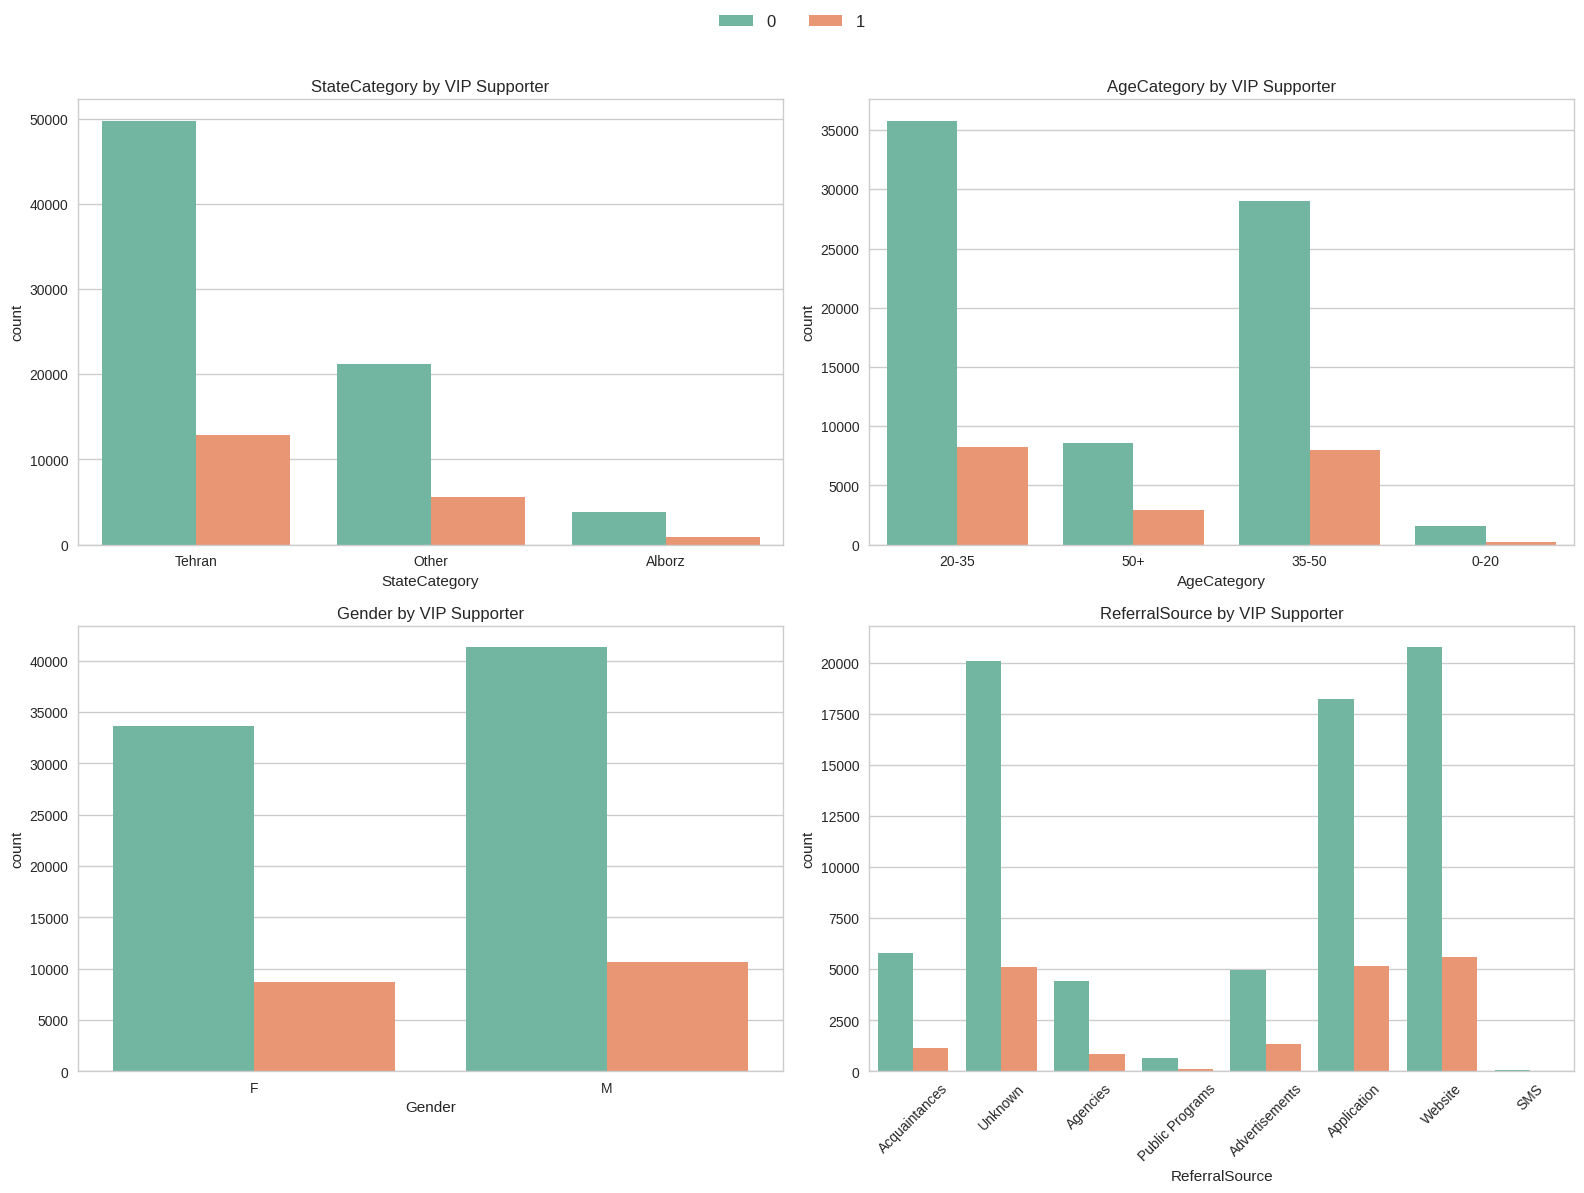

In [107]:
vip_col = "VIP Supporter"

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

categorical_cols = ['StateCategory', 'AgeCategory', 'Gender', 'ReferralSource']

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    sns.countplot(
        x=col, 
        hue=vip_col,
        data=Charity, 
        ax=ax,
        palette="Set2",
        dodge=True
    )
    ax.set_title(f"{col} by VIP Supporter")
    
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    
    if col == 'ReferralSource':
        ax.tick_params(axis='x', rotation=45)
    else:
        ax.tick_params(axis='x', rotation=0)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# <p style="font-family:newtimeroman;color:#FFD700;font-size:80%;text-align:center;border-radius:10px 10px;">Fitting Decision Tree Model</p>

In [108]:
nominal = ['Gender', 'ReferralSource', 'StateCategory']
ordinal = ['AgeCategory']

preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), nominal),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=5,
        criterion='entropy',
        class_weight='balanced',
        min_samples_split=8,
        min_samples_leaf=5,
        random_state=880,
    ))
])

In [109]:
X_Charity = Charity.drop(columns=['VIP Supporter'])
y_Charity = Charity['VIP Supporter']

In [110]:
clf = pipeline.fit(X_Charity, y_Charity)
clf

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'ReferralSource',
                                                   'StateCategory']),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['AgeCategory'])])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=5,
                                        min_samples_leaf=5, min_samples_split=8,
                                        random_state=880))])

In [111]:
X_encoded = pd.DataFrame(
    pipeline.named_steps['preprocessing'].transform(X_Charity),
    columns=pipeline.named_steps['preprocessing'].get_feature_names_out(),
    index=X_Charity.index
)

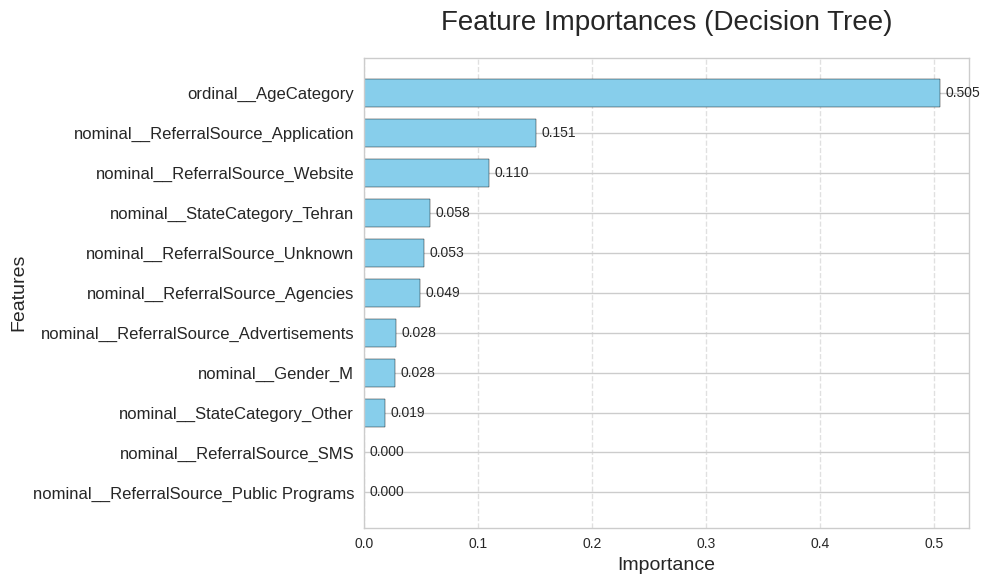

In [112]:
importances = pipeline.named_steps['classifier'].feature_importances_
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()

# Sort features by importance in descending order
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Decision Tree)", fontsize=20, pad=20)

# Horizontal bar plot
plt.barh(range(len(feature_names)), importances[indices], 
         color="skyblue", edgecolor="black", height=0.7)

# Set feature names on y-axis
plt.yticks(range(len(feature_names)), feature_names[indices], fontsize=12)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)

# Invert y-axis so the most important feature appears on top
plt.gca().invert_yaxis()

# Add importance values to each bar
for i, v in enumerate(importances[indices]):
    plt.text(v + 0.005, i, f"{v:.3f}", va="center", fontsize=10)

# Add gridlines for readability
plt.grid(axis="x", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

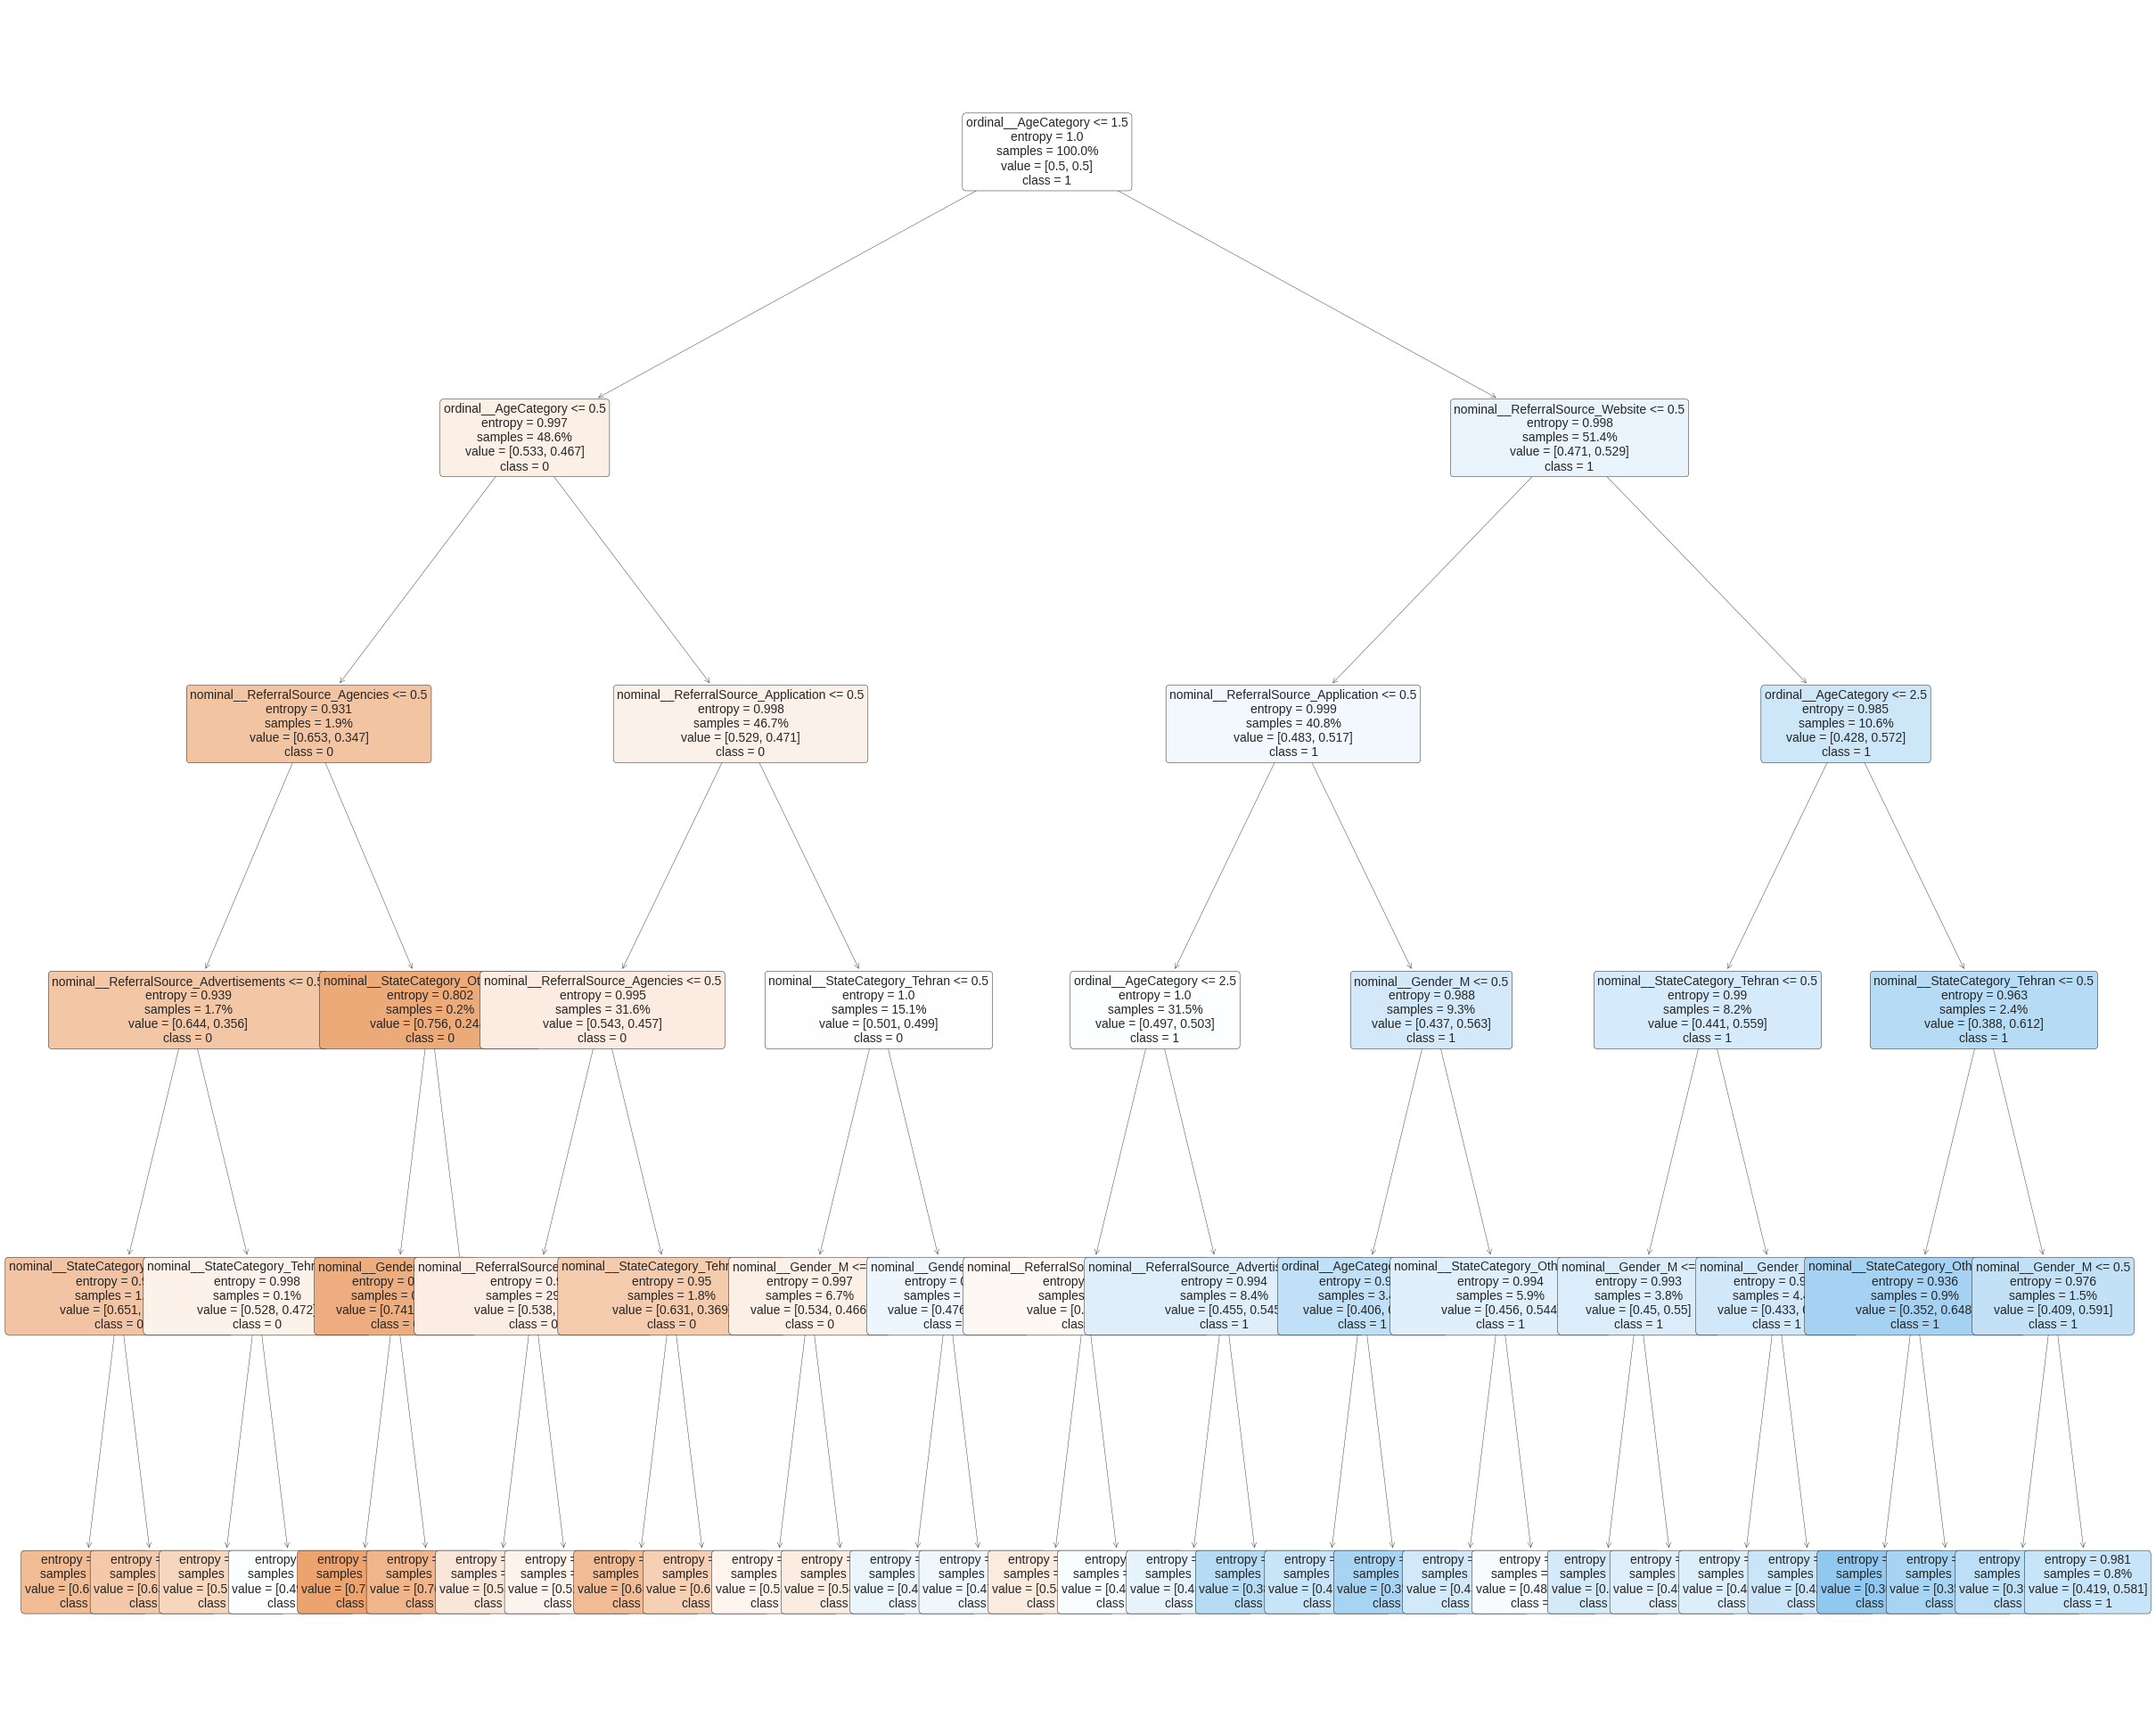

In [113]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(30,25))

clf = pipeline.named_steps['classifier']

plot_tree(clf,
          feature_names=pipeline.named_steps['preprocessing'].get_feature_names_out(),
          class_names=[str(c) for c in clf.classes_],
          proportion=True,
          filled=True,
          rounded=True,
          fontsize=10)
plt.show()

In [114]:
tree_rules = export_text(
    pipeline.named_steps['classifier'],
    feature_names=list(pipeline.named_steps['preprocessing'].get_feature_names_out()),
    spacing=3,
    decimals=2,
    show_weights=True
)

print(tree_rules)

|--- ordinal__AgeCategory <= 1.50
|   |--- ordinal__AgeCategory <= 0.50
|   |   |--- nominal__ReferralSource_Agencies <= 0.50
|   |   |   |--- nominal__ReferralSource_Advertisements <= 0.50
|   |   |   |   |--- nominal__StateCategory_Tehran <= 0.50
|   |   |   |   |   |--- weights: [275.56, 126.68] class: 0
|   |   |   |   |--- nominal__StateCategory_Tehran >  0.50
|   |   |   |   |   |--- weights: [580.05, 331.31] class: 0
|   |   |   |--- nominal__ReferralSource_Advertisements >  0.50
|   |   |   |   |--- nominal__StateCategory_Tehran <= 0.50
|   |   |   |   |   |--- weights: [14.47, 9.74] class: 0
|   |   |   |   |--- nominal__StateCategory_Tehran >  0.50
|   |   |   |   |   |--- weights: [26.42, 26.80] class: 1
|   |   |--- nominal__ReferralSource_Agencies >  0.50
|   |   |   |--- nominal__StateCategory_Other <= 0.50
|   |   |   |   |--- nominal__Gender_M <= 0.50
|   |   |   |   |   |--- weights: [36.49, 9.74] class: 0
|   |   |   |   |--- nominal__Gender_M >  0.50
|   |   |   |   

In [115]:
def get_decision_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    rules = []
    
    def recurse(node, depth, rule=[]):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            rule_left = rule + [f"{name} <= {threshold:.2f}"]
            recurse(tree_.children_left[node], depth + 1, rule_left)
            rule_right = rule + [f"{name} > {threshold:.2f}"]
            recurse(tree_.children_right[node], depth + 1, rule_right)
        else:
            # Get the predicted class for the leaf node
            predicted_class = np.argmax(tree_.value[node])
            # Append the rule with the consequent
            rules.append((rule, predicted_class))
    
    recurse(0, 1)
    return rules

# Extract the decision rules
#rules = get_decision_rules(clf.named_steps['classifier'], feature_names)

In [116]:
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()

rules = get_decision_rules(clf, feature_names)

In [117]:
# Function to calculate lift, support, and confidence for each rule
def calculate_metrics_for_rule(df, rule, target_column='Target'):
    subset = df.copy()
    for condition in rule:
        if ' <= ' in condition:
            feature, value = condition.split(' <= ')
            subset = subset[subset[feature] <= float(value)]
        elif ' > ' in condition:
            feature, value = condition.split(' > ')
            subset = subset[subset[feature] > float(value)]
    
    support = len(subset) / len(df)
    if len(subset) > 0:
        confidence = len(subset[subset[target_column] == 1]) / len(subset)
    else:
        confidence = 0
    lift = confidence / (len(df[df[target_column] == 1]) / len(df))
    
    return support, confidence, lift

# Create a DataFrame to store rules, metrics, and consequents
rule_metrics = []

# Add the target variable to the encoded DataFrame
X_encoded = pd.DataFrame(X_encoded, columns=feature_names)
X_encoded['Target'] = y_Charity

for rule, consequent in rules:
    support, confidence, lift = calculate_metrics_for_rule(X_encoded, rule)
    rule_metrics.append({
        'Rule': ' AND '.join(rule),
        'Consequent': consequent,  # Add the predicted class as the consequent
        'Support': support,
        'Confidence': confidence,
        'Lift': lift
    })

# Convert the list of dictionaries into a DataFrame
rules_df = pd.DataFrame(rule_metrics)

rules_df = rules_df.reset_index(drop=True)
rules_df.insert(0, 'Row', range(1, len(rules_df) + 1))
rules_df.index = rules_df['Row']
rules_df = rules_df.drop(columns=['Row'])



# Set the maximum column width so that long rules are displayed fully
pd.set_option('display.max_colwidth', None)


rules_df = rules_df.sort_values(by='Lift', ascending=False)

rules_df = rules_df.reset_index(drop=True)
rules_df.index = rules_df.index + 1

rules_df

,Rule,Consequent,Support,Confidence,Lift
1,ordinal__AgeCategory > 1.50 AND nominal__ReferralSource_Website > 0.50 AND ordinal__AgeCategory > 2.50 AND nominal__StateCategory_Tehran <= 0.50 AND nominal__StateCategory_Other <= 0.50,1,0.00,0.37,1.81
2,ordinal__AgeCategory > 1.50 AND nominal__ReferralSource_Website > 0.50 AND ordinal__AgeCategory > 2.50 AND nominal__StateCategory_Tehran <= 0.50 AND nominal__StateCategory_Other > 0.50,1,0.01,0.32,1.54
3,ordinal__AgeCategory > 1.50 AND nominal__ReferralSource_Website <= 0.50 AND nominal__ReferralSource_Application > 0.50 AND nominal__Gender_M <= 0.50 AND ordinal__AgeCategory > 2.50,1,0.01,0.32,1.54
4,ordinal__AgeCategory > 1.50 AND nominal__ReferralSource_Website <= 0.50 AND nominal__ReferralSource_Application <= 0.50 AND ordinal__AgeCategory > 2.50 AND nominal__ReferralSource_Advertisements > 0.50,1,0.01,0.29,1.42
5,ordinal__AgeCategory > 1.50 AND nominal__ReferralSource_Website > 0.50 AND ordinal__AgeCategory > 2.50 AND nominal__StateCategory_Tehran > 0.50 AND nominal__Gender_M <= 0.50,1,0.01,0.28,1.37
6,ordinal__AgeCategory > 1.50 AND nominal__ReferralSource_Website > 0.50 AND ordinal__AgeCategory > 2.50 AND nominal__StateCategory_Tehran > 0.50 AND nominal__Gender_M > 0.50,1,0.01,0.26,1.29
7,ordinal__AgeCategory > 1.50 AND nominal__ReferralSource_Website <= 0.50 AND nominal__ReferralSource_Application > 0.50 AND nominal__Gender_M <= 0.50 AND ordinal__AgeCategory <= 2.50,1,0.03,0.26,1.28
8,ordinal__AgeCategory > 1.50 AND nominal__ReferralSource_Website > 0.50 AND ordinal__AgeCategory <= 2.50 AND nominal__StateCategory_Tehran > 0.50 AND nominal__Gender_M > 0.50,1,0.03,0.26,1.27
9,ordinal__AgeCategory > 1.50 AND nominal__ReferralSource_Website <= 0.50 AND nominal__ReferralSource_Application > 0.50 AND nominal__Gender_M > 0.50 AND nominal__StateCategory_Other <= 0.50,1,0.04,0.25,1.22
10,ordinal__AgeCategory > 1.50 AND nominal__ReferralSource_Website > 0.50 AND ordinal__AgeCategory <= 2.50 AND nominal__StateCategory_Tehran <= 0.50 AND nominal__Gender_M <= 0.50,1,0.01,0.25,1.21


---

## 📝 Conclusions and Recommendations

Based on the analysis and segmentation, the charity group can derive the following conclusions and recommendations:

 - ✅ Effective Segmentation: Members are segmented into distinct groups based on their donation behavior, providing a clear understanding of different behavioral patterns.

 - ✅ Target Market Identification: Accurate identification of target groups for campaign implementation, enhancing the effectiveness of marketing strategies.

 - ✅ Member Profiling: Profiling members based on their general characteristics and donation behavior, offering valuable insights into the key traits of potential benefactors.

**The processed data and insights gained from this analysis will help the charity group in designing targeted marketing strategies and implementing successful advertising campaigns.**

---

📝 Based on the analysis of the rules derived from the decision tree model, it appears logical to segment supporters into three main age groups: under 20 years old, between 20 and 35 years old, and over 35 years old. Although all three groups are important, the primary focus should be on the over-35 group, as historical data indicates that they have consistently demonstrated higher engagement and contribution levels.

- **✅ Under 20 years old**  
  - Concentrate efforts on subscribers located in Tehran.  
  - Target through **advertisements** and the **mobile application**, which are the most effective channels for reaching younger audiences.

- **✅ Between 20 and 35 years old**  
  - Include all subscribers regardless of gender or city of residence.  
  - Use both the **website** and the **mobile application** for outreach, as this strategy is most effective for engaging this segment.

- **✅ Over 35 years old**  
  - Focus initially on supporters in **Tehran**, followed by **Alborz**, and then other cities.  
  - Leverage multiple channels, including the **mobile application**, **advertisements**, and the **website**, to maximize participation and contributions.  
  - Prioritizing this group builds on historical patterns of high engagement and optimizes the overall impact of outreach efforts.
